In [1]:
# Imports 


import sys
# setting path
sys.path.append('../core')
import os
#os.environ["VECLIB_MAXIMUM_THREADS"] = "10"

from sklearn.decomposition import PCA

#bread and butter
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#machine learning library
import sklearn
import sklearn.manifold
import sklearn.cluster
import sklearn.decomposition

#statistics
import scipy
from scipy.stats import rankdata, norm

import numba
from numba import jit, njit

from tqdm import tqdm
import copy
import cvxpy as cp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#import numpy as tnp
import warnings
warnings.filterwarnings('ignore')

# import dfply
# from dfply import *
# import ray
# import datetime


import os
import warnings
warnings.filterwarnings("ignore")

#import torch
#torch.cuda.is_available()
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import scipy

import confound_mdp
import confound_ope
import confound_env
import copy
import pickle

from subspace import *
from clustering import *
from emalg import *
from helpers import *

%matplotlib inline
plt.style.use('matplotlibrc')

2023-05-17 15:23:30.407928: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-17 15:23:30.429721: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 15:23:30.702462: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-05-17 15:23:31.141758: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:997] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-17 15:23:31.157650: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:997] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-17 15:23:31.157727: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:997] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Simplifications to Sepsis for Clustering: (1) Rewards no longer dependent on diabetes or no diabetes (averaged across them), (2) Initial state distribution now common across diabetes/no diabetes (averaged across them).

In [2]:
def idx_to_trunc(state_idx, hideGlucose=True, sa=False):
    """idx_to_trunc

    The state index is determined by using "bit" arithmetic, with the
    complication that not every state is binary

    :param state_idx: Given index (720)
    
    Returns a truncated state where the "action states", 
    antibiotics, vasopressors and ventilators, are omitted
    """
    term_base = 720/3 #starts with heart rate

    # Start with the given state index
    mod_idx = state_idx

    hr_state = np.floor(mod_idx/term_base).astype(int)

    mod_idx %= term_base
    term_base /= 3
    sysbp_state = np.floor(mod_idx/term_base).astype(int)

    mod_idx %= term_base
    term_base /= 2
    percoxyg_state = np.floor(mod_idx/term_base).astype(int)

    mod_idx %= term_base
    term_base /= 5
    glucose_state = np.floor(mod_idx/term_base).astype(int)
    
    categ_num = np.array([3,3,2,5])
    state_categs = [
            hr_state,
            sysbp_state,
            percoxyg_state,
            glucose_state]
    if hideGlucose:
        mod_idx %= term_base
        term_base /= 2
        antibiotic_state = np.floor(mod_idx/term_base).astype(int)

        mod_idx %= term_base
        term_base /= 2
        vaso_state = np.floor(mod_idx/term_base).astype(int)

        mod_idx %= term_base
        term_base /= 2
        vent_state = np.floor(mod_idx/term_base).astype(int)
        categ_num = np.array([3,3,2,2,2,2])
        state_categs = [
                hr_state,
                sysbp_state,
                percoxyg_state,
                antibiotic_state,
                vaso_state,
                vent_state]
    sum_idx = 0
    prev_base = 1
    for i in range(len(state_categs)):
        idx = len(state_categs) - 1 - i
        sum_idx += prev_base*state_categs[idx]
        prev_base *= categ_num[idx]
        
    if sa:
        mod_idx %= term_base
        term_base /= 2
        antibiotic_state = np.floor(mod_idx/term_base).astype(int)

        mod_idx %= term_base
        term_base /= 2
        vaso_state = np.floor(mod_idx/term_base).astype(int)

        mod_idx %= term_base
        term_base /= 2
        vent_state = np.floor(mod_idx/term_base).astype(int)
        action = 4*antibiotic_state + 2*vaso_state + 2*vent_state
        return sum_idx, action
    else:
        return sum_idx

idx_to_trunc(719, sa=True)

(143, 0)

In [ ]:
diagnostic = False
#horizons = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
horizon = 60
#n_trajectories = [40,80,120,160,200,240,280,320,360,400,440,480]
#n_trajectories = list(np.arange(10,55,5))
n_trajectories = list(np.arange(100,1100,100))
#n_trajectories = list(np.arange(10,210,10))

hideGlucose = True
import multiprocessing
trials=10

labelsTrials = []
softClustEMsTrials = []
clusterAccsTrials = []
clusterAccsNoProjsTrials = []
classAccsTrials = []
hardClustEMAccsTrials = []
softClustEMAccsTrials = []
hardEMAccsTrials = []
softEMAccsTrials = []
datasetsTrials = []
softEMsTrials = []


for trial in range(trials):
        
    clusterAccs = []
    clusterAccsNoProjs = []
    modelEstims = []
    classAccs = []
    hardClustEMs = []
    hardClustEMAccs = []
    softClustEMs = []
    softClustEMAccs = []
    hardEMs = []
    hardEMAccs = []
    softEMs = []
    softEMAccs = []
    labelsTrial = []
    
    start_seed = trial*multiprocessing.cpu_count()
    print("Trial", trial, "with start seed", start_seed)

    datasets_trajs = []
    datasets_truncs = []

    for n_samples in n_trajectories:
        print("Current Horizon is:", horizon)
        print("Current Trajectories is:", n_samples)

        #########SETUP#########

        # Get the transition and reward matrix from file
        with open("./data/diab_txr_mats-replication.pkl", "rb") as f:
            mdict = pickle.load(f)

        envs = []

        P = mdict["tx_mat"]
        x_dist = mdict["p_initial_state"].mean(0)
        u_dist = mdict["p_mixture"]
        gamma = 1


        #nStates = P.shape[2]
        nActions = P.shape[1]

        R = mdict["r_mat"].mean(0)

        pi_b = np.load('data/sepsisPol.npy')
        pi_e = pi_b.mean(0)

        term = -1
        mdp = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

        np.random.seed(start_seed)
        dataset = confound_mdp.collect_sample(n_samples, mdp, pi_b, horizon, iid=False)
        datasets_trajs.append(np.copy(dataset))

        for m in tqdm(range(dataset.shape[0])):
            for t in range(dataset.shape[1]):
                #s, a, u, s', r
                dataset[m,t,0] = idx_to_trunc(dataset[m,t,0], hideGlucose=hideGlucose)
                dataset[m,t,3] = idx_to_trunc(dataset[m,t,3], hideGlucose=hideGlucose)

        datasets_truncs.append(np.copy(dataset))


        nStates = int(720/8) if not hideGlucose else int(720/(5))

        stateactions = dataset[:, :, [0, 1]]
        memorder = 'C'

        if memorder == 'F':
            stateactions = (dataset[:,:,0] + dataset[:,:,1]*nStates).astype(int) #we code (S x A) as s + a|S|, 0,16,32,48 1,17,33,49
        else:
            stateactions = (dataset[:,:,0]*nActions + dataset[:,:,1]).astype(int)
        states = (dataset[:,:,0]).astype(int)
        actions = (dataset[:,:,1]).astype(int)
        currstates = dataset[:,:,[0,1]].astype(int)
        confounders = dataset[:,:,2].astype(int)
        labels = confounders[:,0].astype(int)
        nextstates = dataset[:,:,3].astype(int)

        L = 2
        K = 2
        #S = nStates*nActions
        #N = len(threes)


        ########SUBSPACE ESTIMATION########

        sadim = nStates*nActions
        spdim = nStates
        omegaone = np.array([i for i in range(int(horizon/4), 2*int(horizon/4))])
        omegatwo = np.array([i for i in range(3*int(horizon/4), horizon)])
        onehotsa = np.eye(sadim)[stateactions]
        #onehotsaflat = copy.deepcopy(onehotsa)
        onehotsa = onehotsa.reshape((onehotsa.shape[0], onehotsa.shape[1], nStates, nActions), order=memorder)
        onehotsp = np.eye(np.max(nextstates)+1)[nextstates]
        sz = int(onehotsa.shape[0]/3)

        eigvalsa, eigvecsa = getEig(onehotsa[:sz], onehotsp[:sz], omegaone, omegatwo, K, wt=True, smalldata=False, device='/GPU:0')


        #########CLUSTERING#########

        device = "/GPU:0"

        hs = np.array([geth(onehotsa[sz:,omegaone,:,:], 
                                         onehotsp[sz:,omegaone,:]), 
                                  geth(onehotsa[sz:,omegatwo,:,:], 
                                       onehotsp[sz:,omegatwo,:])], dtype=np.float32)

        statmns = computeStat(hs, 
                          eigvecsa, numpy=False, smalldata=False, device=device, proj=True)

        statNoProjs = computeStat(hs, 
                          eigvecsa, numpy=False, smalldata=False, device=device, proj=False)
        if diagnostic:
            hi = 0.00005 if hideGlucose else 0.00012
            clusterDiagnostics(statmns, K=K, labels=confounders[sz:, 0],
                           lo=0, hi=hi, step=0.02*hi) #0,0.01, 0.0001
            plt.show()
            clusterDiagnostics(statNoProjs, K=K, labels=confounders[sz:, 0],
                       lo=0, hi=hi, step=0.02*hi) #0,0.01, 0.0001
            plt.show()


        thresh = 2e-5 if hideGlucose else 0.00003 #0.0005
        clusterlabs = sklearn.cluster.spectral_clustering((statmns < thresh).astype(int), n_clusters=2,
                                                         assign_labels='kmeans')

        clusterlabsNoProjs = sklearn.cluster.spectral_clustering((statNoProjs < thresh).astype(int), n_clusters=2,
                                                         assign_labels='kmeans')

        permutation = np.argmax([np.mean(clusterlabs == confounders[sz:, 0]), 
                        np.mean(clusterlabs != confounders[sz:, 0])])
        if diagnostic:
            print(permutation, np.max([np.mean(clusterlabs == confounders[sz:, 0]), 
                        np.mean(clusterlabs != confounders[sz:, 0])]))
        clusterAccs.append(np.max([np.mean(clusterlabs == confounders[sz:, 0]), 
                        np.mean(clusterlabs != confounders[sz:, 0])]))

        clusterAccsNoProjs.append(np.max([np.mean(clusterlabsNoProjs == confounders[sz:, 0]), 
                        np.mean(clusterlabsNoProjs != confounders[sz:, 0])]))

        ########MODEL ESTIMATION#########
        Phat_ksa = getModelEstim(clusterlabs.astype(int), 
                             states[sz:,:], 
                             actions[sz:,:], 
                             nextstates[sz:,:],
                            K=K, nStates=nStates, nActions=nActions, hard=True)
        modelEstims.append(Phat_ksa)


        ########CLASSIFICATION#########
        priorclass = np.bincount(clusterlabs)/len(clusterlabs) 
        piclust = getPolicyEstim(states[sz:], actions[sz:], 
                                 K, nStates, nActions, preds=clusterlabs, hard=True)
        startweights = getStartWeights(states[sz:], clusterlabs, K, nStates)
        subspaceClass = classify(Phat_ksa, states[:sz,:], actions[:sz,:], 
                               nextstates[:sz,:], piclust, reg=1, 
                           prior=priorclass, startweights = startweights, labs=True)
        if diagnostic:
            print('Subspace Classification accuracy:', [np.mean(labels[:sz] == subspaceClass), 
                                                    np.mean(labels[:sz] != subspaceClass)][permutation])
        classAccs.append([np.mean(labels[:sz] == subspaceClass), np.mean(labels[:sz] != subspaceClass)][permutation])


        ########EM ALGORITHM########
        priorclass = np.bincount(clusterlabs)/len(clusterlabs) 
        piclust = getPolicyEstim(states[sz:], actions[sz:], 
                                 K, nStates, nActions, preds=clusterlabs, hard=True)

        startweights = getStartWeights(states[sz:], clusterlabs, K, nStates)
        maxapos = classify(Phat_ksa, states, actions, 
                               nextstates, piclust, reg=1, 
                           prior=priorclass, startweights = startweights, labs=True)
        mleprobs = classify(Phat_ksa, states, actions, 
                               nextstates, piclust, reg=1, 
                            prior=priorclass, startweights = startweights, labs=False)
        if diagnostic:
            print('MAP estimate overall accuracy:', [np.mean(labels == maxapos), np.mean(labels != maxapos)][permutation])

        # HARD EM
        expectclass, modelestimclass, loglikclass = em(maxapos, 
                                Phat_ksa, states, actions, 
                            nextstates, labels=labels, 
                            K=K, nStates=nStates, nActions=nActions,
                            prior = priorclass, reg = 1, max_iter=100,
                                                   permute=False, permutation=permutation,
                                                   checkin=1, hard=True, verbose=False)
        hardClustEMs.append([expectclass, modelestimclass, loglikclass])
        hardClustEMAccs.append(np.max([np.mean(labels == expectclass), np.mean(labels != expectclass)]))

        # SOFT EM
        normprobs = np.exp(mleprobs-np.max(mleprobs))
        regprobs = 0.8*(normprobs)/np.nansum(np.abs(normprobs), 0) + 0.1*np.ones(mleprobs.shape)
        expectclasssoft, modelestimclasssoft, loglikclasssoft = em(regprobs, 
                                    Phat_ksa, states, actions, 
                                nextstates, labels, 
                                K=2, nStates=nStates, nActions=nActions,
                                prior = priorclass, reg = 1, permute=False,
                                permutation=permutation, checkin=1, hard=False, verbose=False)
        softClustEMs.append([expectclasssoft, modelestimclasssoft, loglikclasssoft])
        softClustEMAccs.append(np.max([np.mean(labels == expectclasssoft.argmax(0)),
                                np.mean(labels != expectclasssoft.argmax(0))]))
        print("Soft Clust EM Acc:", np.max([np.mean(labels == expectclasssoft.argmax(0)),
                                np.mean(labels != expectclasssoft.argmax(0))]))

        #############BASE EM###############

        labelsem = []
        logliksem = []
        for i in tqdm(range(30)):
            randlabs = np.random.binomial(1, 0.5, size=len(dataset)).astype(int)
            randmodel = getModelEstim(randlabs, states, actions, nextstates,
                                      K, nStates, nActions, hard=True)
            randlabs, randmodel, loglikrand = em(randlabs, randmodel,
               states, actions, nextstates, labels, 
                                K=K, nStates=nStates, nActions=nActions,
                                prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=True)
            labelsem.append(randlabs)
            logliksem.append(loglikrand)
        if diagnostic:
            plt.figure(figsize=(12,7))
            plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem], logliksem)
            print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
            print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
            print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
            plt.xlabel('Accuracy')
            plt.ylabel('Log-likelihood')
            plt.title('Randomly Initialized Hard EM Algorithm')
            plt.show()
            plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem])
            plt.show()
        hardEMAccs.append(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
        hardEMs.append([labelsem, logliksem])

        labelsemsoft = []
        logliksemsoft = []
        for i in tqdm(range(30)):
            unifs = np.random.uniform(size=len(dataset))
            randlabsoft = np.vstack([unifs, 1-unifs])
            randmodelsoft = getModelEstim(randlabsoft, states, actions, nextstates,
                                      K, nStates, nActions, hard=False)
            randlabsoft, randmodelsoft, loglikrand = em(randlabsoft, randmodelsoft,
           states, actions, nextstates, labels, 
                                K=K, nStates=nStates, nActions=nActions,
                                prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=False)
            labelsemsoft.append(randlabsoft)
            logliksemsoft.append(loglikrand)
        if diagnostic:
            plt.figure(figsize=(12,7))
            plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)], 
                        logliksemsoft)
            print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
            print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
            print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
            plt.ticklabel_format(style='plain',useOffset=False)
            plt.xlabel('Accuracy')
            plt.ylabel('Log-likelihood')
            plt.title('Randomly Initialized Soft EM Algorithm')
            plt.show()
            plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)])
            plt.show()
        softEMAccs.append(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
        softEMs.append([labelsemsoft, logliksemsoft])
    
    
    clusterAccsTrials.append(clusterAccs)
    clusterAccsNoProjsTrials.append(clusterAccsNoProjs)
    classAccsTrials.append(classAccs)
    hardClustEMAccsTrials.append(hardClustEMAccs)
    softClustEMAccsTrials.append(softClustEMAccs)
    hardEMAccsTrials.append(hardEMAccs)
    softEMAccsTrials.append(softEMAccs)
    labelsTrial.append(clusterlabs)
    softClustEMsTrials.append(softClustEMs)
    datasetsTrials.append(datasets_trajs)
    softEMsTrials.append(softEMs)
        

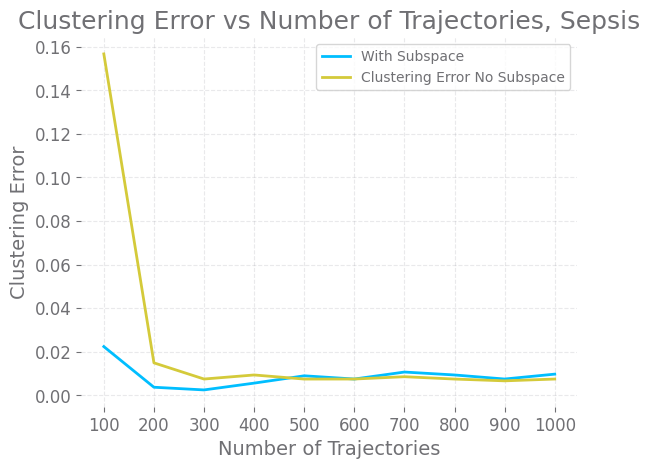

In [4]:
#plt.figure(figsize=(16,9))
plt.plot(1-np.median(np.array(clusterAccsTrials),0), label='With Subspace')
plt.plot(1-np.median(np.array(clusterAccsNoProjsTrials),0), label='Clustering Error No Subspace')
plt.ylabel("Clustering Error")
plt.xlabel("Number of Trajectories")
plt.xticks(ticks = np.arange(len(n_trajectories)),labels=n_trajectories) 
plt.title("Clustering Error vs Number of Trajectories, Sepsis")
plt.legend()
#plt.savefig('figs/SepsisClustering.png')

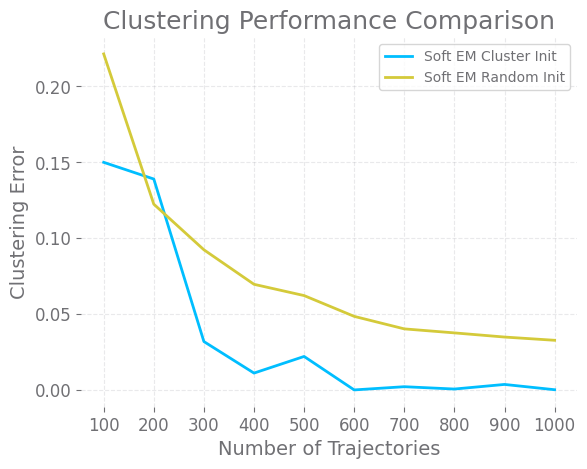

In [5]:
#plt.figure(figsize=(16,9))
'''
plt.plot(horizons, 1-np.median(np.array(hardClustEMAccsTrials),0),
         label='Hard EM Cluster Init')
plt.plot(horizons, 1-np.median(np.array(hardEMAccsTrials),0),
        label='Hard EM')
'''       
plt.plot(1-np.mean(np.array(softClustEMAccsTrials),0),
         label='Soft EM Cluster Init')
plt.plot(1-np.mean(np.array(softEMAccsTrials),0),
        label='Soft EM Random Init')

plt.xticks(ticks = np.arange(len(n_trajectories)),labels=n_trajectories) 
plt.ylabel("Clustering Error")
plt.xlabel("Number of Trajectories")
plt.title("Clustering Performance Comparison")
plt.legend()
plt.savefig('figs/SepsisEMCompMean.png')

## Off-Policy Evaluation

In [6]:
preds = [[clust[0].argmax(0) for clust in softClustEMs] for softClustEMs in softClustEMsTrials]

In [7]:
Rhat_sa = getR_sa(datasetsTrials[-1][-2], 720, nActions)
Rhat_asp = getR_asp(datasetsTrials[-1][-2], 720, nActions)

In [8]:
datasets = [[[datasetsTrial[i][(datasetsTrial[i][...,2] == k)[:,0]] 
              for k in range(K)] 
                 for i in range(len(datasetsTrial))]
                for datasetsTrial in datasetsTrials]
datasets_estim = [[[datasetsTrial[i][preds[t][i] == ((k + permutation)%2)] 
              for k in range(K)] 
                 for i in range(len(datasetsTrial))] 
                  for t,datasetsTrial in enumerate(datasetsTrials)] #n_trajs, u, dataset
#t, i, labels/loglik, 30 EM runs
datasets_estim_rand = [[[datasetsTrial[i][softEMsTrials[t][i][0][-1].argmax(0) == ((k + permutation)%2)] 
              for k in range(K)] 
                 for i in range(len(datasetsTrial))] 
                  for t,datasetsTrial in enumerate(datasetsTrials)]

In [ ]:
fqes_true = [[[confound_ope.fitted_q_evaluation(pi_e, datasets[t][i][k], horizon, mdp) for k in range(K)] 
             for i in range(len(n_trajectories))] for t in range(trials)]
fqes_estim = [[[confound_ope.fitted_q_evaluation(pi_e, datasets_estim[t][i][k], horizon, mdp) for k in range(K)]
             for i in range(len(n_trajectories))] for t in range(trials)]
fqes_estim_rand = [[[confound_ope.fitted_q_evaluation(pi_e, datasets_estim_rand[t][i][k], horizon, mdp) for k in range(K)]
             for i in range(len(n_trajectories))] for t in range(trials)]
fqes_estim_mean = [[confound_ope.fitted_q_evaluation(pi_e, datasetsTrials[t][i], horizon, mdp)
             for i in range(len(n_trajectories))] for t in range(trials)]

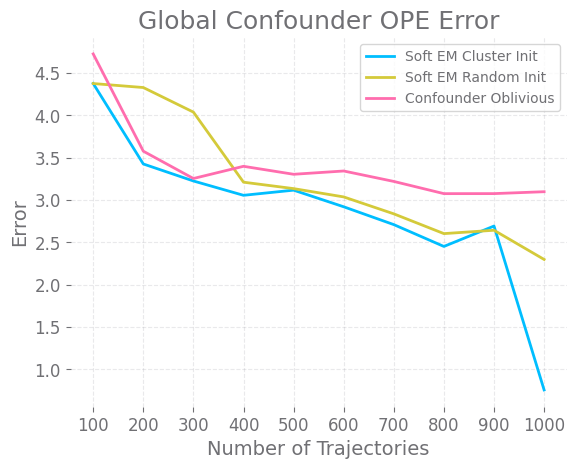

In [10]:
vals_true = np.array([[[(fqes_true[t][-1][k] * pi_e).sum(1) * u_dist[(k + permutation)%2] 
                          for k in range(K)] 
                            for i in range(len(n_trajectories))] 
                                for t in range(trials)]).sum(2)

vals_estim = np.array([[[(fqes_estim[t][i][k] * pi_e).sum(1) * u_dist[(k + permutation)%2] 
                          for k in range(K)] 
                            for i in range(len(n_trajectories))] 
                                for t in range(trials)]).sum(2)

vals_estim_rand = np.array([[[(fqes_estim_rand[t][i][k] * pi_e).sum(1) * u_dist[(k + permutation)%2] 
                          for k in range(K)] 
                            for i in range(len(n_trajectories))] 
                                for t in range(trials)]).sum(2)

vals_estim_mean = np.array([[(fqes_estim_mean[t][i] * pi_e).sum(1)
                            for i in range(len(n_trajectories))] 
                                for t in range(trials)])

plt.plot(np.max(np.abs(vals_true - vals_estim),2).mean(0), label='Soft EM Cluster Init')
plt.plot(np.max(np.abs(vals_true - vals_estim_rand),2).mean(0), label='Soft EM Random Init')
plt.plot(np.max(np.abs(vals_true - vals_estim_mean),2).mean(0), label='Confounder Oblivious')

plt.xticks(ticks = np.arange(len(n_trajectories)),labels=n_trajectories) 
plt.title('Global Confounder OPE Error')
plt.xlabel('Number of Trajectories')
plt.ylabel('Error')
plt.legend()
plt.savefig('figs/globalOPElarge.png')

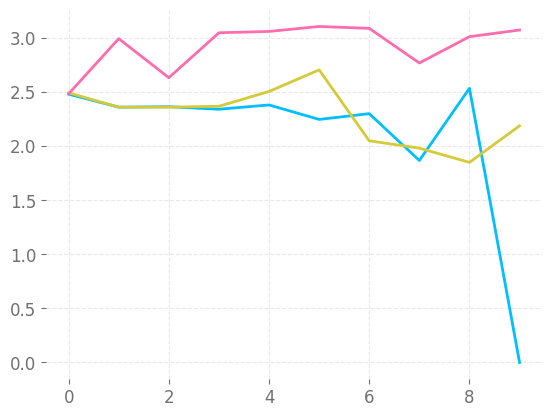

In [11]:
plt.plot(np.median(np.nanmax(np.abs(vals_true - vals_estim),2),0))
plt.plot(np.median(np.nanmax(np.abs(vals_true - vals_estim_rand),2),0))
plt.plot(np.median(np.nanmax(np.abs(vals_true - vals_estim_mean),2),0))

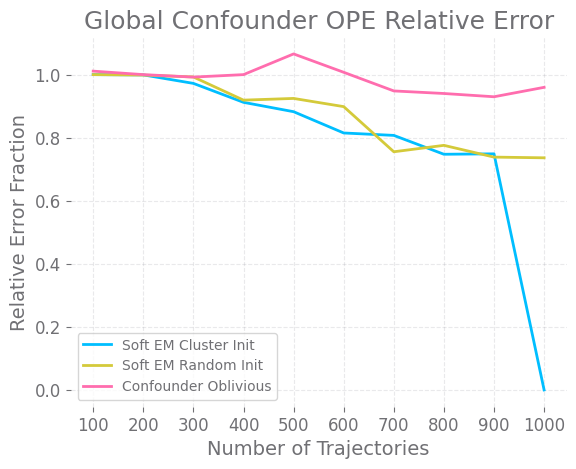

In [12]:
plt.plot(np.median(np.nanmax(np.abs(vals_true - vals_estim),2)/np.max(np.abs(vals_true),2),0), label='Soft EM Cluster Init')
plt.plot(np.median(np.nanmax(np.abs(vals_true - vals_estim_rand),2)/np.max(np.abs(vals_true),2), 0), label='Soft EM Random Init')
plt.plot(np.median(np.nanmax(np.abs(vals_true - vals_estim_mean),2)/np.max(np.abs(vals_true),2), 0), label='Confounder Oblivious')
plt.xticks(ticks = np.arange(len(n_trajectories)),labels=n_trajectories) 
plt.title('Global Confounder OPE Relative Error')
plt.xlabel('Number of Trajectories')
plt.ylabel('Relative Error Fraction')
plt.legend()
plt.savefig('figs/globalOPERelLargeMedian.png')

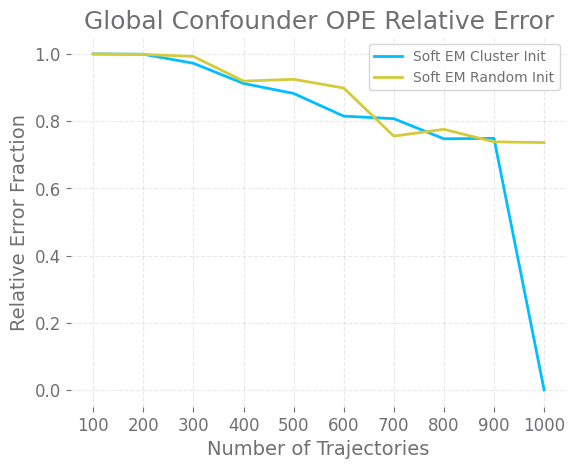

In [13]:
plt.plot(np.median(np.nanmax(np.abs(vals_true - vals_estim),2)/np.max(np.abs(vals_true),2),0), label='Soft EM Cluster Init')
plt.plot(np.median(np.nanmax(np.abs(vals_true - vals_estim_rand),2)/np.max(np.abs(vals_true),2), 0), label='Soft EM Random Init')
#plt.plot(np.median(np.nanmax(np.abs(vals_true - vals_estim_mean),2)/np.max(np.abs(vals_true),2), 0), label='Confounder Unaware')
plt.xticks(ticks = np.arange(len(n_trajectories)),labels=n_trajectories) 
plt.title('Global Confounder OPE Relative Error')
plt.xlabel('Number of Trajectories')
plt.ylabel('Relative Error Fraction')
plt.legend()
plt.savefig('figs/globalOPERelLargeMedianAware.png')

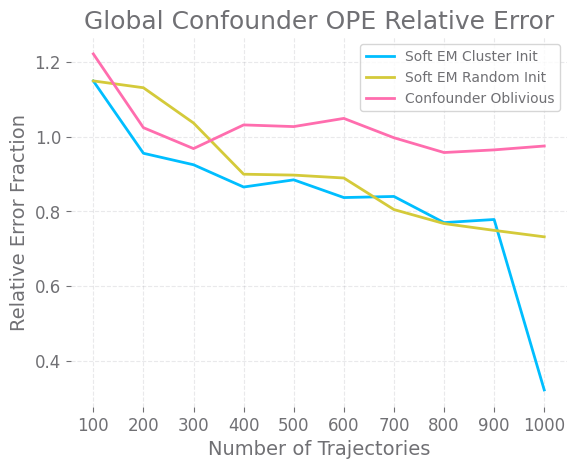

In [14]:
plt.plot((np.nanmax(np.abs(vals_true - vals_estim),2)/np.max(np.abs(vals_true),2)).mean(0), label='Soft EM Cluster Init')
plt.plot((np.nanmax(np.abs(vals_true - vals_estim_rand),2)/np.max(np.abs(vals_true),2)).mean(0), label='Soft EM Random Init')
plt.plot((np.nanmax(np.abs(vals_true - vals_estim_mean),2)/np.max(np.abs(vals_true),2)).mean(0), label='Confounder Oblivious')
plt.xticks(ticks = np.arange(len(n_trajectories)),labels=n_trajectories) 
plt.title('Global Confounder OPE Relative Error')
plt.xlabel('Number of Trajectories')
plt.ylabel('Relative Error Fraction')
plt.legend()
plt.savefig('figs/globalOPERelLarge.png')

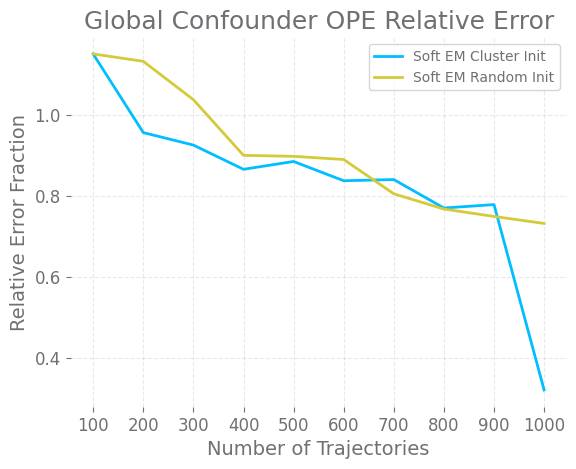

In [15]:
plt.plot((np.nanmax(np.abs(vals_true - vals_estim),2)/np.max(np.abs(vals_true),2)).mean(0), label='Soft EM Cluster Init')
plt.plot((np.nanmax(np.abs(vals_true - vals_estim_rand),2)/np.max(np.abs(vals_true),2)).mean(0), label='Soft EM Random Init')
#plt.plot((np.nanmax(np.abs(vals_true - vals_estim_mean),2)/np.max(np.abs(vals_true),2)).mean(0), label='Confounder Unaware')
plt.xticks(ticks = np.arange(len(n_trajectories)),labels=n_trajectories) 
plt.title('Global Confounder OPE Relative Error')
plt.xlabel('Number of Trajectories')
plt.ylabel('Relative Error Fraction')
plt.legend()
plt.savefig('figs/globalOPERelLargeAware.png')

## Optimization

In [16]:
rescale=True
rescaled_data = []
for k in range(K):
    rescaled_data_k = np.copy(datasets_estim[-1][-1][k])
    if rescale:
        rescaled_rewards = rescaled_data_k[:,:,4]
        rescaled_rewards = (rescaled_rewards - rescaled_rewards.mean()) / rescaled_rewards.std()
        rescaled_data_k[:,:,4] = rescaled_rewards
    rescaled_data.append(rescaled_data_k)
    
rescaled_data_rand = []
for k in range(K):
    rescaled_data_rand_k = np.copy(datasets_estim_rand[-1][-1][k])
    if rescale:
        rescaled_rewards = rescaled_data_rand_k[:,:,4]
        rescaled_rewards = (rescaled_rewards - rescaled_rewards.mean()) / rescaled_rewards.std()
        rescaled_data_rand_k[:,:,4] = rescaled_rewards
    rescaled_data_rand.append(rescaled_data_rand_k)
    

rescaled_data_mean = np.copy(np.vstack(datasets_estim_rand[-1][-1]))
if rescale:
    rescaled_rewards = rescaled_data_mean[:,:,4]
    rescaled_rewards = (rescaled_rewards - rescaled_rewards.mean()) / rescaled_rewards.std()
    rescaled_data_mean[:,:,4] = rescaled_rewards


100%|██████████| 60/60 [00:07<00:00,  7.51it/s]

100%|██████████| 60/60 [00:01<00:00, 31.37it/s]

100%|██████████| 60/60 [00:07<00:00,  7.64it/s]

100%|██████████| 60/60 [00:02<00:00, 29.52it/s]

100%|██████████| 60/60 [00:10<00:00,  5.92it/s]


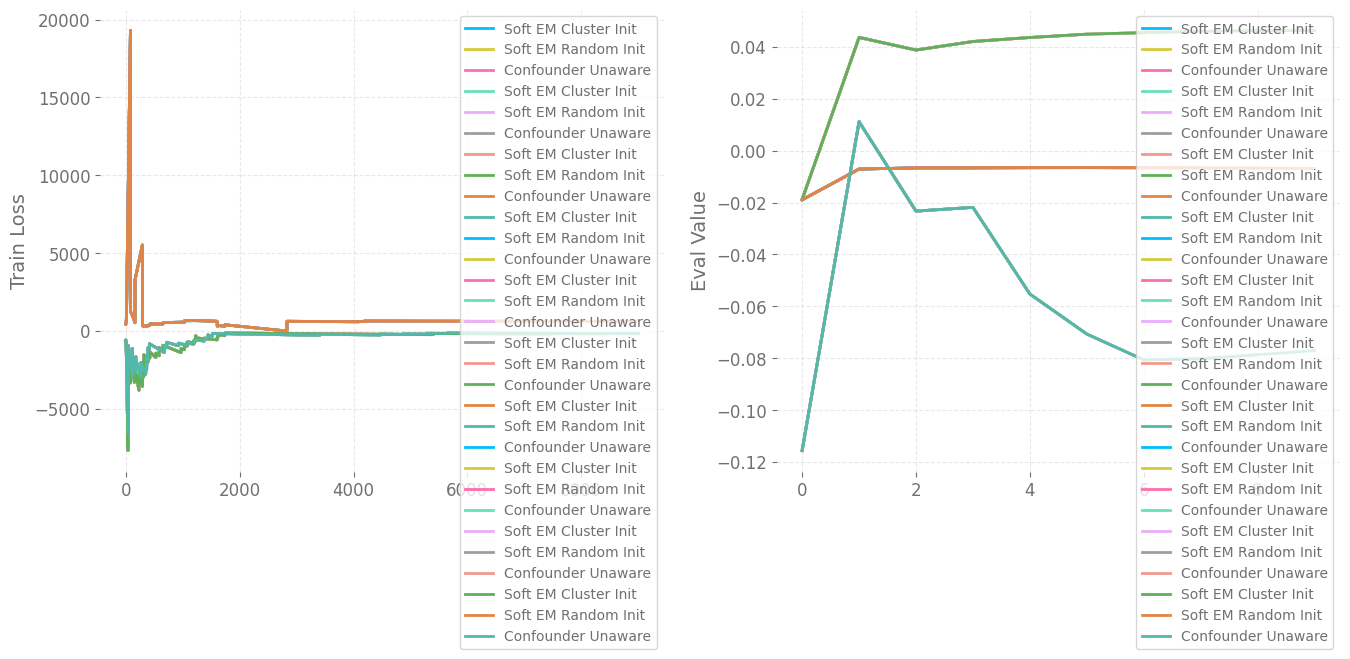

100%|██████████| 10000/10000 [22:20<00:00,  7.46it/s] 


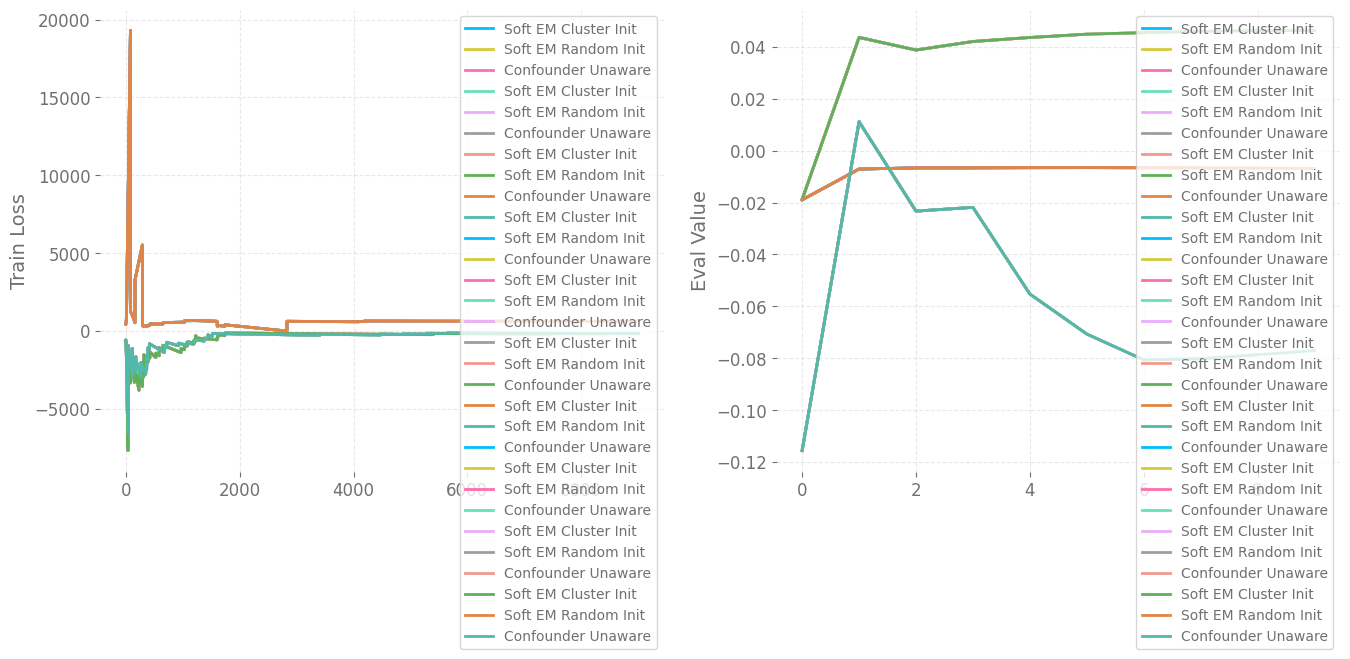

In [17]:
import jax
import jax.numpy as jnp

from IPython.display import display, clear_output

def random_choice_prob_index(a, axis=0):
    r = np.expand_dims(np.random.rand(a.shape[1-axis]), axis=axis)
    return (a.cumsum(axis=axis) > r).argmax(axis=axis)

FEATURE_DIM = 720
weights = jnp.array(np.random.normal(size=(nActions, FEATURE_DIM)))# @ jnp.array(jnp.eye(FEATURE_DIM)[200])
weights = jnp.array(pi_b.mean(0).T) #NOTE: this is shaped A x S.
weights_rand = jnp.array(pi_b.mean(0).T)
weights_mean = jnp.array(pi_b.mean(0).T)


def get_loss(trajectory, weights, pi_b, FEATURE_DIM, pred_label, mean=False):
    states_traj = trajectory[:,0].astype(int)
    actions_traj = trajectory[:,1].astype(int)
    rewards_traj = trajectory[:,4]
    policy = jax.nn.softmax(weights, axis=0)
    probs = jnp.take(policy, states_traj, axis=1)
    if mean:
        is_weights = (probs[states_traj,actions_traj]
                      /(pi_b * u_dist[:,None,None]).sum(0)[states_traj,actions_traj])
    else:
        is_weights = probs[states_traj,actions_traj]/pi_b[pred_label][states_traj,actions_traj]
    #is_weights = jnp.clip(is_weights, np.sqrt(len(trajectory))) #truncated importance sampling
    loss = - jnp.nansum(
        jax.lax.stop_gradient(is_weights)
        * rewards_traj 
        * jnp.log(
            jnp.take(jnp.take(probs,actions_traj,axis=1),
                     jnp.arange(len(trajectory)),axis=0))
    )
    return loss

get_loss = jax.vmap(get_loss, (0,None,None,None,None,None), 0)

def loss_batch(dataset, weights, pi_b, FEATURE_DIM, pred_label, mean=False):
    losses = get_loss(dataset, weights, pi_b, FEATURE_DIM, pred_label, mean)
    return jnp.nanmean(losses.at[jnp.isinf(losses)].set(0))

loss_grad = jax.value_and_grad(loss_batch, argnums=1)


eta = 0.05
values = []
values_rand = []
values_mean = []
fqe_evals = []
fqe_evals_rand = []
fqe_evals_mean = []
'''
fqe_evals.append(((np.array([(confound_ope.fitted_q_evaluation(pi_b.mean(0), datasets[-1][-1][k], horizon, mdp) * pi_b.mean(0)).sum(1) 
         for k in range(K)]) * u_dist[:,None]).sum(0)*x_dist).sum())
'''
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
#loss_batch(jnp.array(datasets_trajs[-1]), weights, jnp.array(pi_b), FEATURE_DIM)
for t in tqdm(range(10000)):
    loss = 0
    for k in range(K):
        pred_label = (k + permutation)%2
        loss_k, grad_k = loss_grad(jnp.array(rescaled_data[k]), weights, 
                                   jnp.array(pi_b), FEATURE_DIM, pred_label)
        loss += loss_k * u_dist[pred_label]
        weights -= eta * grad_k * u_dist[pred_label]
    weights = weights.at[jnp.isinf(weights)].set(0)
    weights = weights.at[jnp.isnan(weights)].set(0)
    values.append(loss)
    
    loss_rand = 0
    for k in range(K):
        pred_label = (k + permutation)%2
        loss_rand_k, grad_rand_k = loss_grad(jnp.array(rescaled_data_rand[k]), weights_rand, 
                                             jnp.array(pi_b), FEATURE_DIM, pred_label)
        loss_rand += loss_rand_k * u_dist[pred_label]
        weights_rand -= eta * grad_k * u_dist[pred_label]
    weights_rand = weights_rand.at[jnp.isinf(weights_rand)].set(0)
    weights_rand = weights_rand.at[jnp.isnan(weights_rand)].set(0)
    values_rand.append(loss_rand)
    
    
    loss_mean, grad_mean = loss_grad(jnp.array(rescaled_data_mean), weights_mean, 
                                             jnp.array(pi_b), FEATURE_DIM, pred_label, mean=True)
    weights_mean -= eta * grad_mean
    weights_mean = weights_mean.at[jnp.isinf(weights_mean)].set(0)
    weights_mean = weights_mean.at[jnp.isnan(weights_mean)].set(0)
    values_mean.append(loss_mean)
    
    if t % 1000 == 0:
        clear_output(wait = True)
        ax1.plot(values, label='Soft EM Cluster Init')
        ax1.plot(values_rand, label='Soft EM Random Init')
        ax1.plot(values_mean, label='Confounder Unaware')
        ax1.legend()
        ax1.set_ylabel('Train Loss')
        policy = np.array(jax.nn.softmax(weights, 0).T)
        policy_rand = np.array(jax.nn.softmax(weights_rand, 0).T)
        policy_mean = np.array(jax.nn.softmax(weights_mean, 0).T)
        fqe_eval = ((np.array([(confound_ope.fitted_q_evaluation(policy, 
                                    datasets[-1][-1][k], horizon, mdp) * policy).sum(1) 
                     for k in range(K)]) * u_dist[:,None]).mean(0) * x_dist).sum()
        fqe_eval_rand = ((np.array([(confound_ope.fitted_q_evaluation(policy_rand, 
                                    datasets[-1][-1][k], horizon, mdp) * policy_rand).sum(1) 
                     for k in range(K)]) * u_dist[:,None]).mean(0) * x_dist).sum()
        fqe_eval_mean = ((confound_ope.fitted_q_evaluation(policy_mean, 
                    np.vstack(datasets[-1][-1]), horizon, mdp) * policy_mean).sum(1) * x_dist).sum()
        #fqe_eval = -(np.array([loss_batch(jnp.array(datasets[-1][-1][k]), weights, jnp.array(pi_b), FEATURE_DIM, 0) 
        # for k in range(K)]) * u_dist[:,None]).mean(0).sum()
        fqe_evals.append(fqe_eval)
        fqe_evals_rand.append(fqe_eval_rand)
        fqe_evals_mean.append(fqe_eval_mean)
        ax2.plot(fqe_evals, label='Soft EM Cluster Init')
        ax2.plot(fqe_evals_rand, label='Soft EM Random Init')
        ax2.plot(fqe_evals_mean, label='Confounder Unaware')
        ax2.legend()
        ax2.set_ylabel('Eval Value')
        display(fig)
    

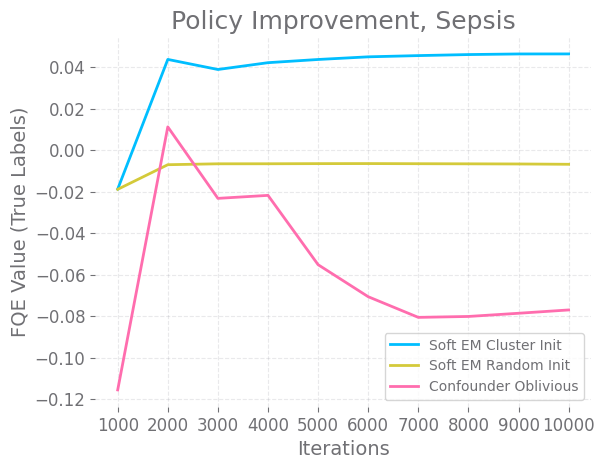

In [18]:
plt.plot(fqe_evals, label='Soft EM Cluster Init')
plt.plot(fqe_evals_rand, label='Soft EM Random Init')
plt.plot(fqe_evals_mean, label='Confounder Oblivious')
plt.xticks(ticks = np.arange(len(fqe_evals)),labels=1000*(1+np.arange(len(fqe_evals)))) 
plt.ylabel('FQE Value (True Labels)')
plt.xlabel('Iterations')
plt.title('Policy Improvement, Sepsis')
plt.legend()
plt.savefig('figs/globalPolicyImprovementHighLR.png')

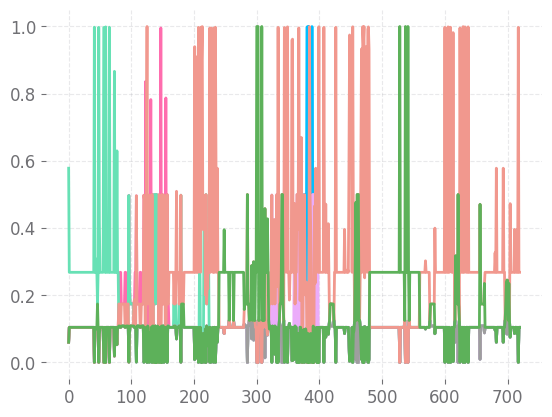

In [19]:
plt.plot(np.array(policy))
plt.show()

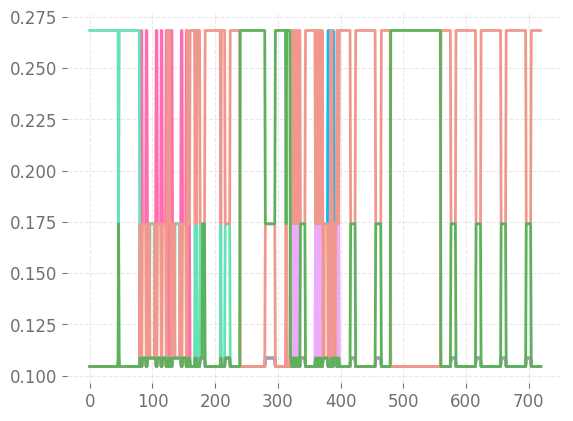

In [20]:
plt.plot(np.array(jax.nn.softmax(pi_b.mean(0),1)))
plt.show()

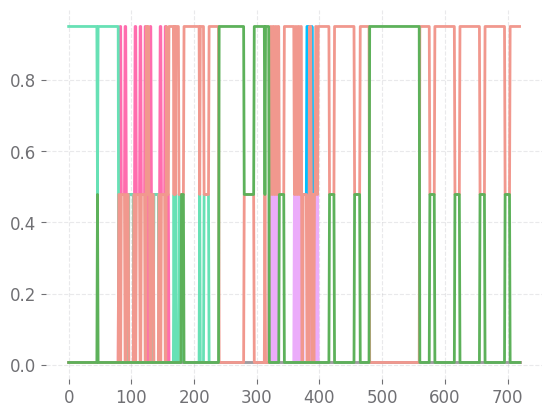

In [21]:
plt.plot(np.array(pi_b.mean(0)))
plt.show()